### TASK 3 (HOUSE HOLD POWER):

In [9]:
!pip install xgboost
!pip install prophet

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.8/150.0 MB 453.5 kB/s eta 0:05:29
   ---------------------------------------- 1.0/150.0 MB 508.4 kB/s eta 0:04:53
   ---------------------------------------- 1.3/150.0 MB 604.7 kB/s eta 0:04:06
   ---------------------------------------- 1.6/150.0 MB 687.7 kB/s eta 0:03:36
   ---------------------------------------- 1.8/150.0 MB 762.8 kB/s eta 0:03:

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')


In [11]:
# Load CSV file
df = pd.read_csv('household_power_consumption.csv')

# Display first few rows
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [12]:
# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Set Datetime as index
df.set_index('Datetime', inplace=True)

# Convert Global_active_power to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Resample to hourly data
df_hourly = df['Global_active_power'].resample('H').mean()

# Drop NaNs
df_hourly = df_hourly.dropna()

# Preview
df_hourly.head()

Datetime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
Name: Global_active_power, dtype: float64

In [13]:
# Create a new dataframe for features
df_features = df_hourly.to_frame().copy()

# Create time-based features
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['is_weekend'] = df_features['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Preview
df_features.head()

,Global_active_power,hour,day_of_week,is_weekend
Datetime,,,,
2006-12-16 17:00:00,4.222889,17,5,1
2006-12-16 18:00:00,3.632200,18,5,1
2006-12-16 19:00:00,3.400233,19,5,1
2006-12-16 20:00:00,3.268567,20,5,1
2006-12-16 21:00:00,3.056467,21,5,1


In [14]:
# Split data into train and test
train = df_hourly[:-168]  # all except last 7 days
test = df_hourly[-168:]   # last 7 days

## ARIMA Model
arima_model = ARIMA(train, order=(5,1,0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))

## Prophet Model
prophet_df = df_hourly.reset_index()
prophet_df.columns = ['ds', 'y']

# Train-test split
prophet_train = prophet_df[:-168]
prophet_test = prophet_df[-168:]

prophet_model = Prophet()
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=168, freq='H')
forecast = prophet_model.predict(future)
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds').iloc[-168:]

## XGBoost Model
# Prepare data
X = df_features.drop('Global_active_power', axis=1)
y = df_features['Global_active_power']

X_train, X_test = X[:-168], X[-168:]
y_train, y_test = y[:-168], y[-168:]

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

18:10:48 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing


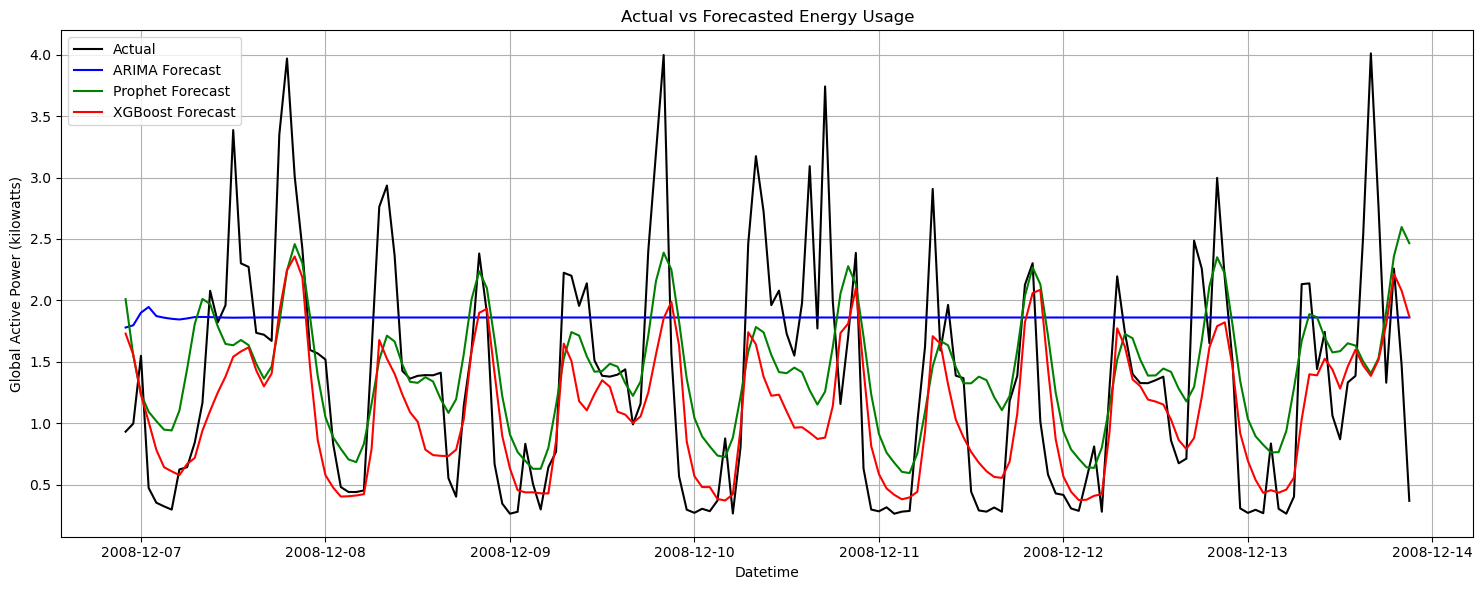

In [15]:
plt.figure(figsize=(15, 6))

# Actual
plt.plot(test.index, test, label='Actual', color='black')

# ARIMA
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue')

# Prophet
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Forecast', color='green')

# XGBoost
plt.plot(test.index, xgb_forecast, label='XGBoost Forecast', color='red')

plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Actual vs Forecasted Energy Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()